<a href="https://colab.research.google.com/github/akshayaa-403/yosemite-image-translation-gan/blob/main/Yosemite_Image_Translation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Visualize the Data

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_data_loader(image_type, image_dir=r'/content/drive/MyDrive/summer2winter_yosemite', image_size=128, batch_size=16, num_workers=0):

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    image_path =  image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [4]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

# Display some Training images

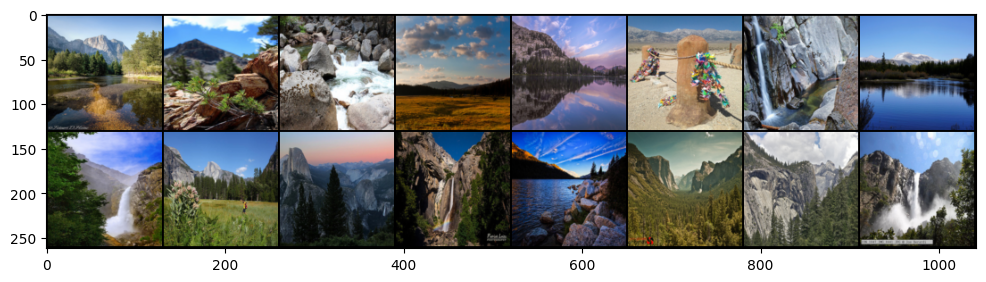

In [5]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(dataloader_X)
images, _ = dataiter.__next__()

fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

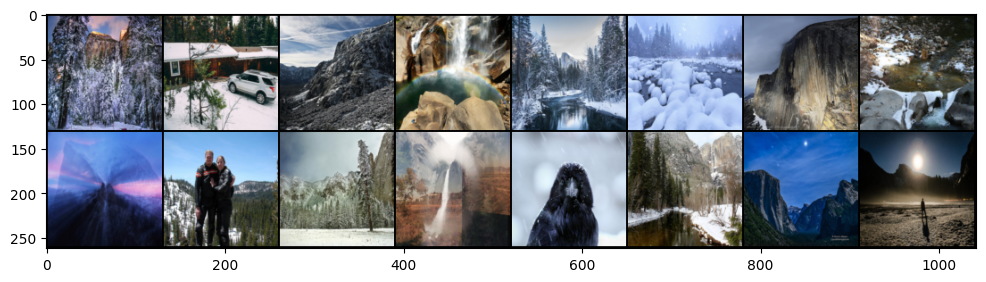

In [6]:
dataiter = iter(dataloader_Y)
images, _ = dataiter.__next__()

fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [7]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0235)
Max:  tensor(0.9843)


In [8]:
def scale(x, feature_range=(-1, 1)):

    min, max = feature_range
    x = x * (max - min) + min
    return x

In [9]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.9529)
Scaled max:  tensor(0.9686)


# Discriminators


In [10]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)

        self.conv5 = conv(conv_dim*8, 1, 8, stride=1, padding=0, batch_norm=False)


    def forward(self, x):

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))

        out = self.conv5(out)
        return out

# Generators


In [12]:
class ResidualBlock(nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()

        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim,
                                kernel_size=3, stride=1, padding=1, batch_norm=True)

        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim,
                               kernel_size=3, stride=1, padding=1, batch_norm=True)

    def forward(self, x):
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):

    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [14]:
class CycleGenerator(nn.Module):

    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))

        self.res_blocks = nn.Sequential(*res_layers)

        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)

        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))

        return out

# Create the complete network


In [15]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):

    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)

    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [16]:
G_XtoY, G_YtoX, D_X, D_Y = create_model()

Models moved to GPU.


# Implementation


In [17]:
def print_models(G_XtoY, G_YtoX, D_X, D_Y):

    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()

print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

# Discriminator and Generator Losses


In [18]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss

In [19]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# Training the Model


In [20]:
!cp /content/drive/MyDrive/summer2winter_yosemite/helpers.py .

In [21]:
from helpers import save_samples, checkpoint

In [22]:
checkpoint_dir = 'checkpoints_cyclegan'
os.makedirs(checkpoint_dir, exist_ok=True)

In [23]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=1000):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print_every = 10
    losses = []
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    fixed_X = next(test_iter_X)[0].to(device)
    fixed_Y = next(test_iter_Y)[0].to(device)
    fixed_X = scale(fixed_X).to(device)
    fixed_Y = scale(fixed_Y).to(device)

    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = next(iter_X)
        images_X = scale(images_X).to(device)

        images_Y, _ = next(iter_Y)
        images_Y = scale(images_Y).to(device)

        d_x_optimizer.zero_grad()

        D_X_real_loss = real_mse_loss(D_X(images_X))
        G_Y2X_fake_image = G_YtoX(images_Y)
        D_X_fake_loss = fake_mse_loss(D_X(G_Y2X_fake_image))

        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        D_Y_real_loss = real_mse_loss(D_Y(images_Y))
        G_X2Y_fake_image = G_XtoY(images_X)
        D_Y_fake_loss = fake_mse_loss(D_Y(G_X2Y_fake_image))

        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()

        g_optimizer.zero_grad()

        G_X_img = G_YtoX(images_Y)
        G_X_real_loss = real_mse_loss(D_X(G_X_img))
        G_Y_reconstructed = G_XtoY(G_X_img)
        G_Y_consistency_loss = cycle_consistency_loss(images_Y, G_Y_reconstructed, 10)

        G_Y_img = G_XtoY(images_X)
        G_Y_real_loss = real_mse_loss(D_Y(G_Y_img))
        G_X_reconstructed = G_YtoX(G_Y_img)
        G_X_consistency_loss = cycle_consistency_loss(images_X, G_X_reconstructed, 10)

        g_total_loss = G_X_real_loss + G_Y_real_loss + G_Y_consistency_loss + G_X_consistency_loss
        g_total_loss.backward()
        g_optimizer.step()

        if epoch % print_every == 0:
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

        sample_every = 100
        if epoch % sample_every == 0:
            G_YtoX.eval()
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every = 1000
        if epoch % checkpoint_every == 0:
             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [24]:
n_epochs = 4000

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

Epoch [   10/ 4000] | d_X_loss: 0.6671 | d_Y_loss: 4.1199 | g_total_loss: 26.0862
Epoch [   20/ 4000] | d_X_loss: 0.7802 | d_Y_loss: 9.5411 | g_total_loss: 18.4641
Epoch [   30/ 4000] | d_X_loss: 0.9230 | d_Y_loss: 9.6045 | g_total_loss: 18.0576
Epoch [   40/ 4000] | d_X_loss: 0.5382 | d_Y_loss: 12.4556 | g_total_loss: 20.0184
Epoch [   50/ 4000] | d_X_loss: 4.9553 | d_Y_loss: 33.0427 | g_total_loss: 18.2789
Epoch [   60/ 4000] | d_X_loss: 0.5301 | d_Y_loss: 26.2014 | g_total_loss: 33.6526
Epoch [   70/ 4000] | d_X_loss: 0.4163 | d_Y_loss: 130.4434 | g_total_loss: 62.0406
Epoch [   80/ 4000] | d_X_loss: 0.5631 | d_Y_loss: 66.5951 | g_total_loss: 45.6245
Epoch [   90/ 4000] | d_X_loss: 0.4952 | d_Y_loss: 147.8197 | g_total_loss: 16.2567
Epoch [  100/ 4000] | d_X_loss: 1.4822 | d_Y_loss: 66.9133 | g_total_loss: 40.8511
Epoch [  110/ 4000] | d_X_loss: 0.3697 | d_Y_loss: 149.2332 | g_total_loss: 16.5069
Epoch [  120/ 4000] | d_X_loss: 0.6437 | d_Y_loss: 354.2227 | g_total_loss: 45.7420
Epo

# Evaluation Metrics

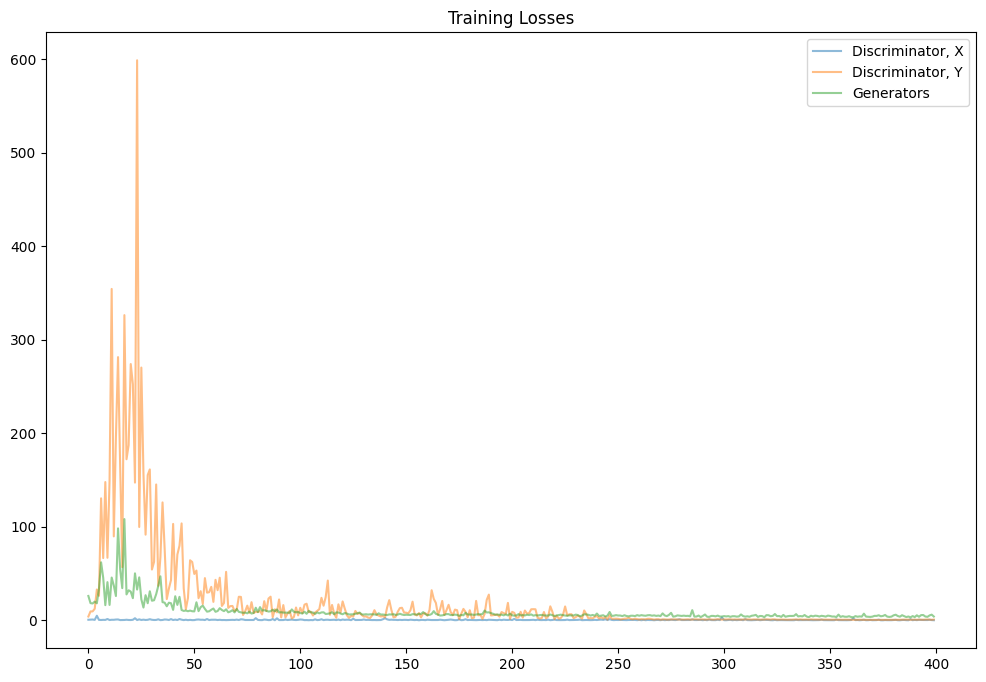

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_samples(iteration, sample_dir='/content/samples'):

    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}.png'.format(iteration))

    try:
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)

        fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
        ax1.imshow(x2y)
        ax1.set_title('X to Y')
        ax2.imshow(y2x)
        ax2.set_title('Y to X')
        plt.show()
    except FileNotFoundError:
        print(f'Samples for iteration {iteration} not found.')

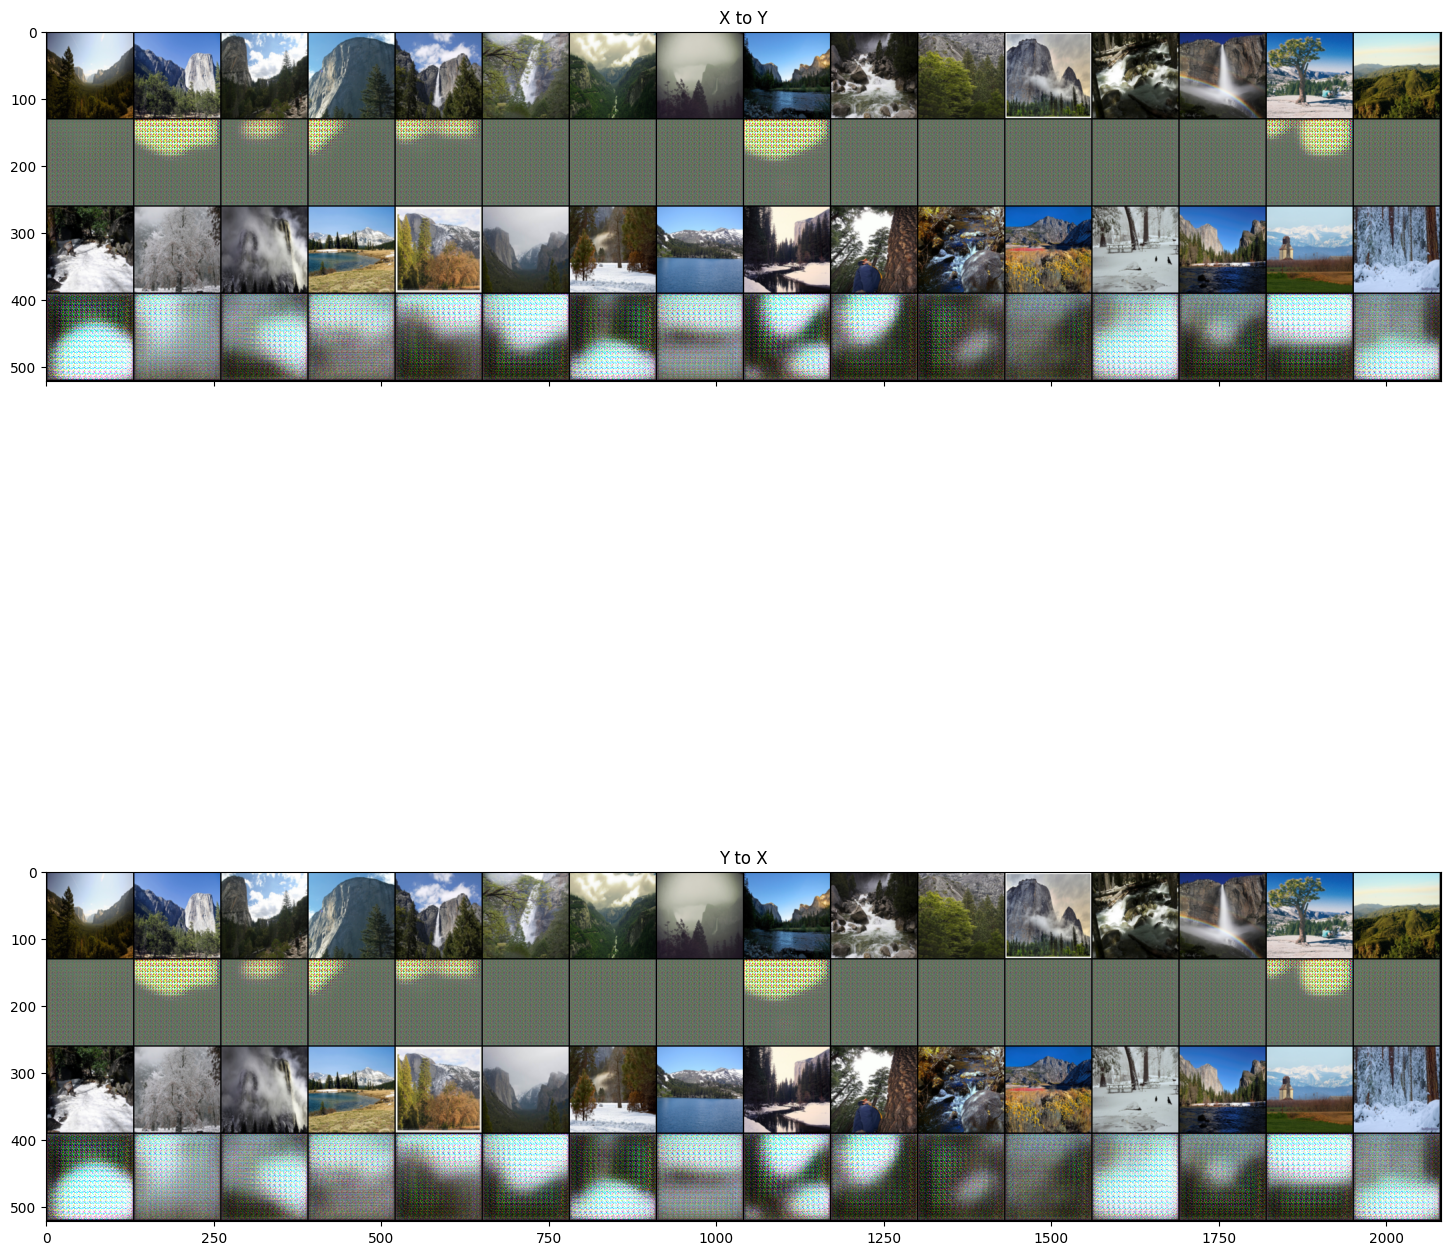

In [27]:
view_samples(100,)

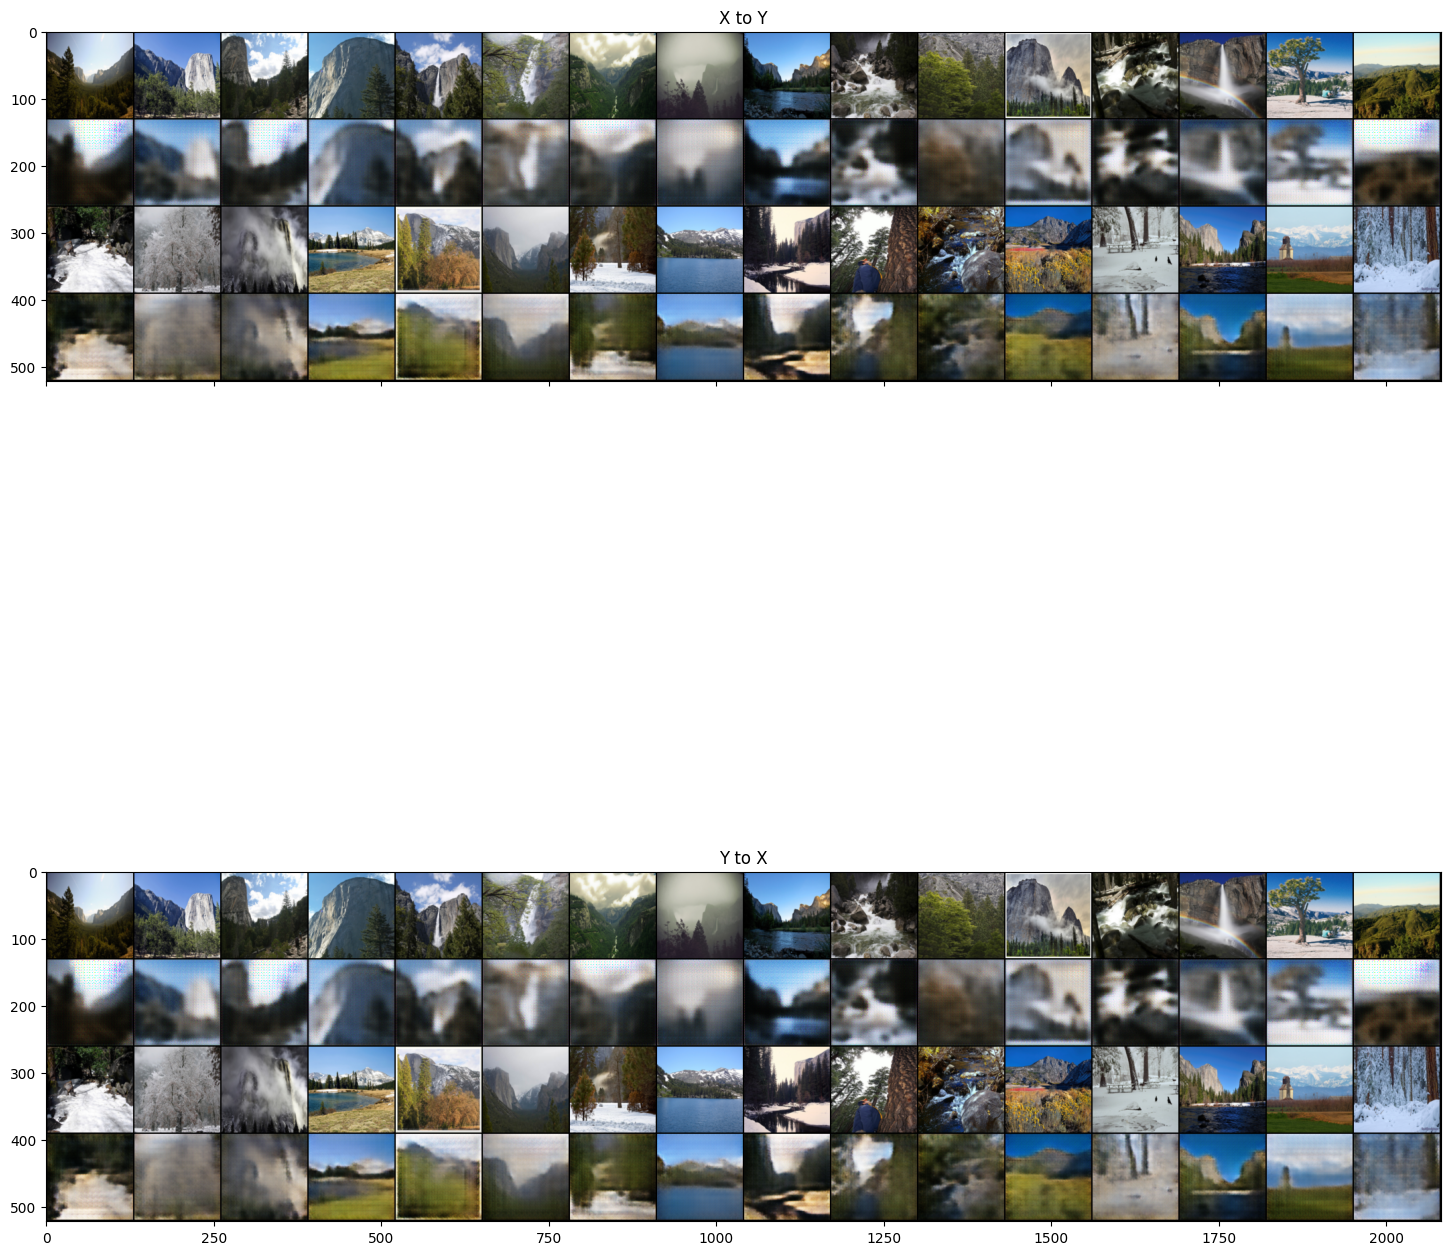

In [28]:
view_samples(4000,)

In [33]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import skimage.transform

def calculate_metrics(original, generated):
    data_range = original.max() - original.min()
    ssim_value = ssim(original, generated, multichannel=True, win_size=3, data_range=data_range)
    psnr_value = psnr(original, generated, data_range=data_range)
    return ssim_value, psnr_value

path_XtoY = '/content/samples/sample-003000.png'
path_YtoX = '/content/samples/sample-003000.png'

try:
    x2y = mpimg.imread(path_XtoY)
    y2x = mpimg.imread(path_YtoX)

    original_X = next(iter(test_dataloader_X))[0][0].permute(1, 2, 0).numpy()
    original_Y = next(iter(test_dataloader_Y))[0][0].permute(1, 2, 0).numpy()

    x2y_resized = skimage.transform.resize(x2y, original_X.shape[:2], anti_aliasing=True)
    y2x_resized = skimage.transform.resize(y2x, original_Y.shape[:2], anti_aliasing=True)

    ssim_x2y, psnr_x2y = calculate_metrics(original_X, x2y_resized)
    ssim_y2x, psnr_y2x = calculate_metrics(original_Y, y2x_resized)

    print(f'SSIM (X to Y): {ssim_x2y:.4f}')
    print(f'PSNR (X to Y): {psnr_x2y:.4f}')

    print(f'SSIM (Y to X): {ssim_y2x:.4f}')
    print(f'PSNR (Y to X): {psnr_y2x:.4f}')

except FileNotFoundError:
    print(f'Samples for iteration 4000 not found.')

SSIM (X to Y): 0.0767
PSNR (X to Y): 7.3007
SSIM (Y to X): 0.0601
PSNR (Y to X): 6.9261
